<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries-and-data" data-toc-modified-id="Import-libraries-and-data-1">Import libraries and data</a></span></li><li><span><a href="#Simple-Prophet-Model" data-toc-modified-id="Simple-Prophet-Model-2">Simple Prophet Model</a></span><ul class="toc-item"><li><span><a href="#Compare-Forecast-to-Actuals" data-toc-modified-id="Compare-Forecast-to-Actuals-2.1">Compare Forecast to Actuals</a></span></li></ul></li><li><span><a href="#Adding-Regressor" data-toc-modified-id="Adding-Regressor-3">Adding Regressor</a></span></li><li><span><a href="#Adding-more-regressors" data-toc-modified-id="Adding-more-regressors-4">Adding more regressors</a></span></li><li><span><a href="#Optimizing-the-model" data-toc-modified-id="Optimizing-the-model-5">Optimizing the model</a></span></li></ul></div>

### Import libraries and data

In [1]:
# Import Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error


import datetime
from datetime import date
import random


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Data
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [3]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H')

In [5]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])

In [6]:
ts = data['2018-06-30':'2018-09-29']
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-06-30 00:00:00,None,302.87,0.0,0.0,1,Clear,sky is clear,2018-06-30 00:00:00,1423
2018-06-30 01:00:00,None,302.58,0.0,0.0,1,Clear,sky is clear,2018-06-30 01:00:00,869
2018-06-30 02:00:00,None,302.55,0.0,0.0,1,Thunderstorm,proximity thunderstorm,2018-06-30 02:00:00,617
2018-06-30 03:00:00,None,302.29,0.0,0.0,40,Rain,moderate rain,2018-06-30 03:00:00,429
2018-06-30 04:00:00,None,301.29,0.0,0.0,1,Rain,light rain,2018-06-30 04:00:00,429


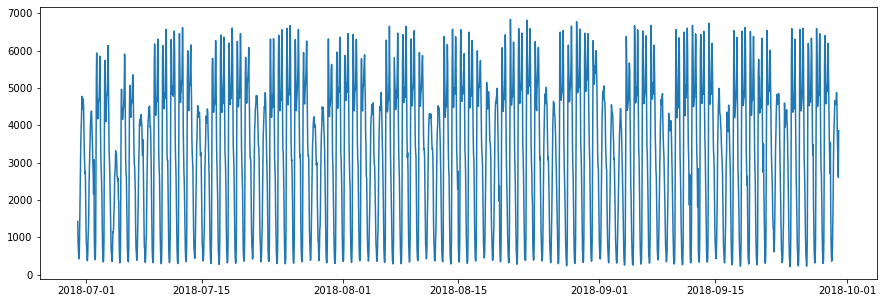

In [7]:
plt.figure(figsize=(15,5))
plt.plot(ts.traffic_volume)
plt.show()

Train/Test Split

In [8]:
split_date = '2018-09-22'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

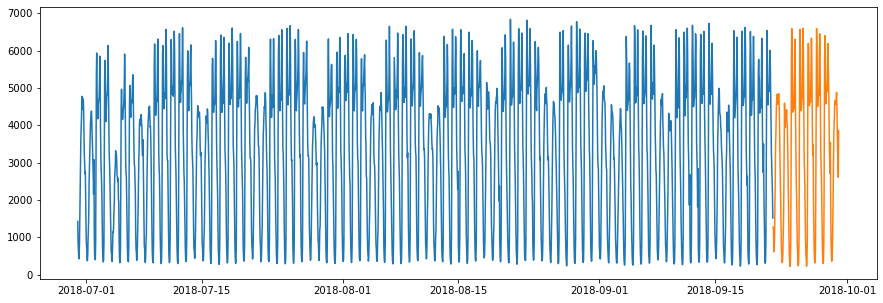

In [9]:
plt.figure(figsize=(15,5))
plt.plot(ts_train.traffic_volume)
plt.plot(ts_test.traffic_volume)
plt.show()

### Simple Prophet Model

In [10]:
ts_train = ts_train.rename(columns={'traffic_volume':'y'})
ts_test = ts_test.rename(columns={'traffic_volume':'y'})

In [11]:
%%time
# Setup and train model
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

model.fit(ts_train)

Wall time: 2.42 s


In [12]:
%%time
# Predict on training set with model
y_pred = model.predict(df=ts_test)

Wall time: 2.03 s


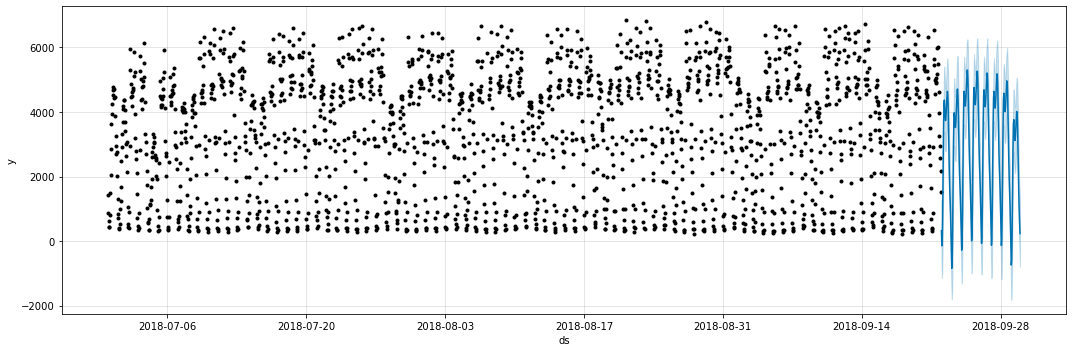

In [13]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(y_pred, ax=ax)

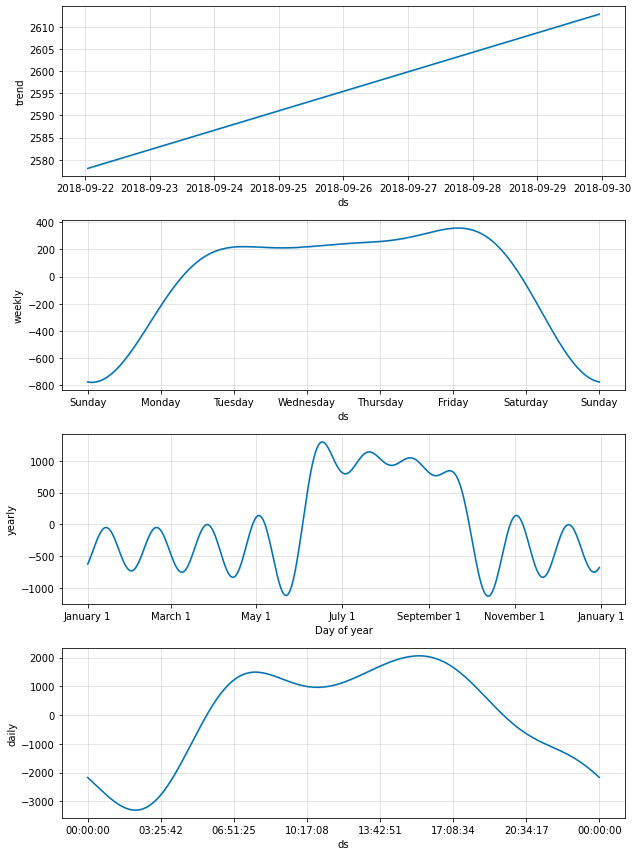

In [14]:
# Plot the components
fig = model.plot_components(y_pred)

#### Compare Forecast to Actuals

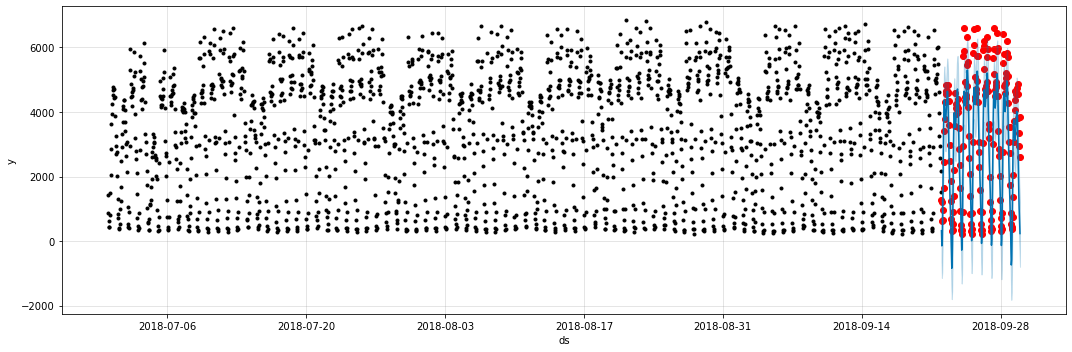

In [15]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.y, color='r')
fig = model.plot(y_pred, ax=ax)

Lastest 2 days

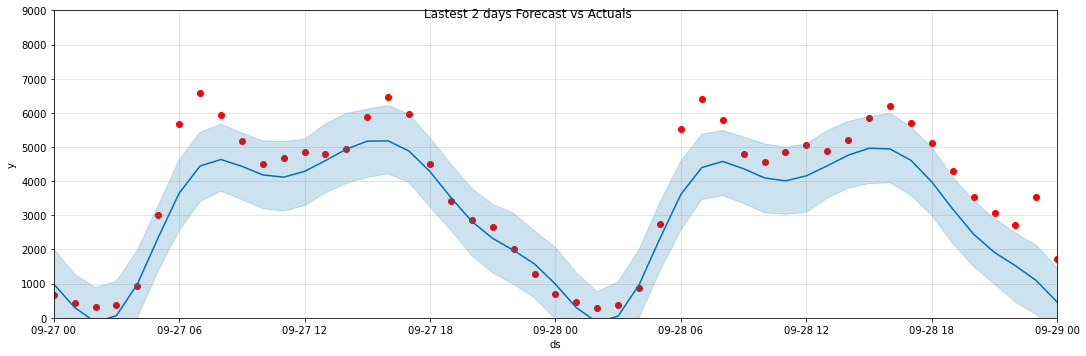

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.y, color='r')
fig = model.plot(y_pred, ax=ax)
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))

ax.set_ylim(0, 9000)
plot = plt.suptitle('Lastest 2 days Forecast vs Actuals')

**Error Metrics**

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
def error_metrics(y_true, y_pred):
    print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('Mean Absolute percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred)))

In [19]:
error_metrics(ts_test.y, y_pred['yhat'])

Mean Absolute Error: 755.68
Root Mean Squared Error: 985.96
Mean Absolute percentage Error: 40.36 %


### Adding Regressor

In [20]:
%%time
# Setup and train model with holidays
model_with_temp = Prophet(weekly_seasonality=True)
model_with_temp.add_regressor('temp')
model_with_temp.fit(df=ts_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Wall time: 1.87 s


In [21]:
%%time
y_pred_1r = model_with_temp.predict(df=ts_test)

Wall time: 2.2 s


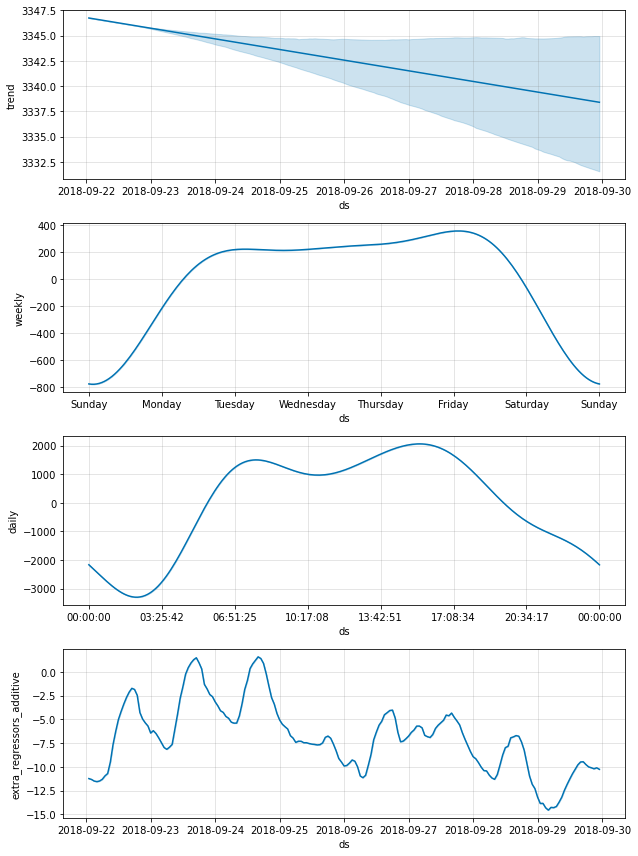

In [22]:
fig2 = model_with_temp.plot_components(y_pred_1r)

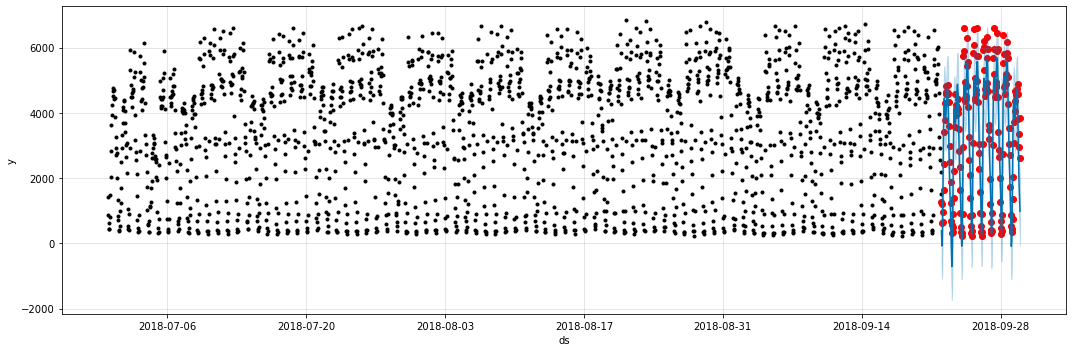

In [23]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.y, color='r')
fig2 = model_with_temp.plot(y_pred_1r, ax=ax)

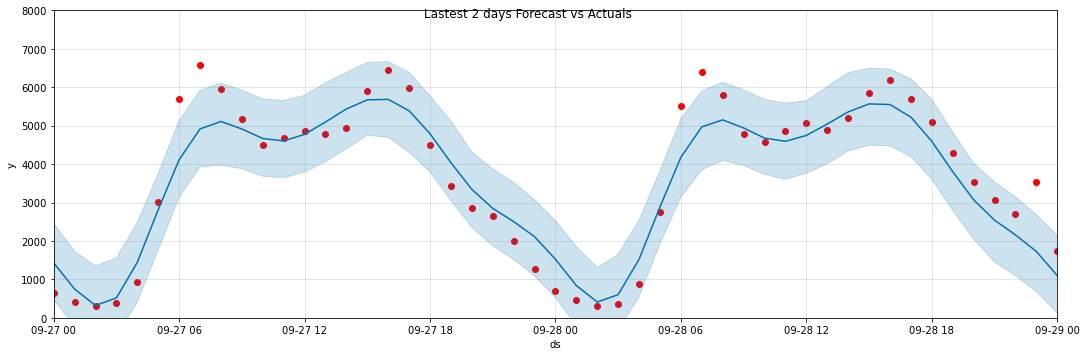

In [24]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.y, color='r')
fig = model.plot(y_pred_1r, ax=ax)
#ax.set_xbound(lower='2018-09-22', upper='2018-09-29')
#ax.set_xbound(lower='2012-10-02 09:00:00', upper='2018-30-29 09:00:00')
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))

ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest 2 days Forecast vs Actuals')

**Error Metrics**

In [25]:
error_metrics(ts_test.y, y_pred_1r['yhat'])

Mean Absolute Error: 636.90
Root Mean Squared Error: 842.02
Mean Absolute percentage Error: 37.79 %


### Adding more regressors

In [26]:
%%time
# Setup and train model with many regressors
model_reg = Prophet(weekly_seasonality=True, daily_seasonality= True)
model_reg.add_regressor('temp')
model_reg.add_regressor('rain_1h')
model_reg.add_regressor('snow_1h')
model_reg.add_regressor('clouds_all')
model_reg.fit(df=ts_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Wall time: 1.09 s


In [27]:
%%time
y_pred_mr = model_reg.predict(df=ts_test)
y_pred_mr.yhat[y_pred_mr.yhat < 0] = 0

Wall time: 2.16 s


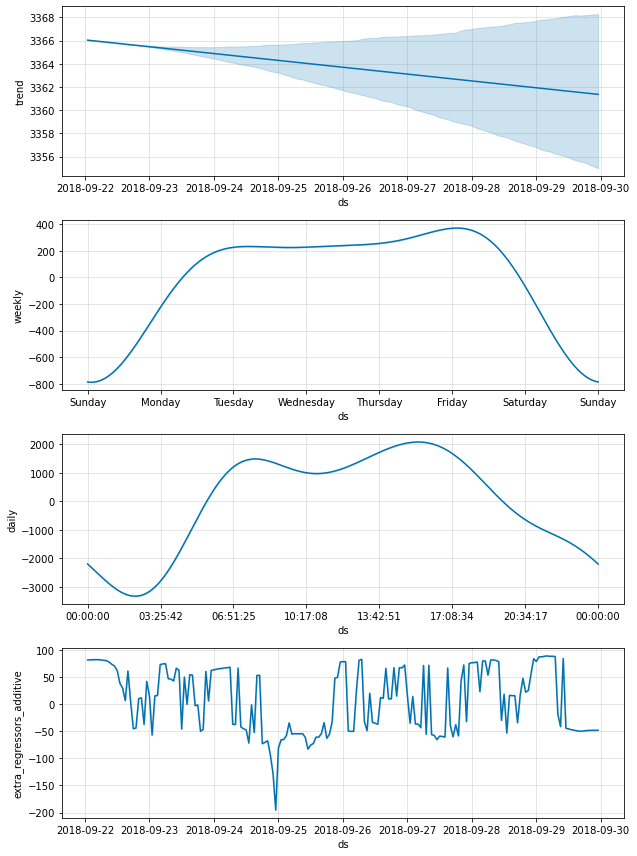

In [28]:
fig2 = model_reg.plot_components(y_pred_mr)

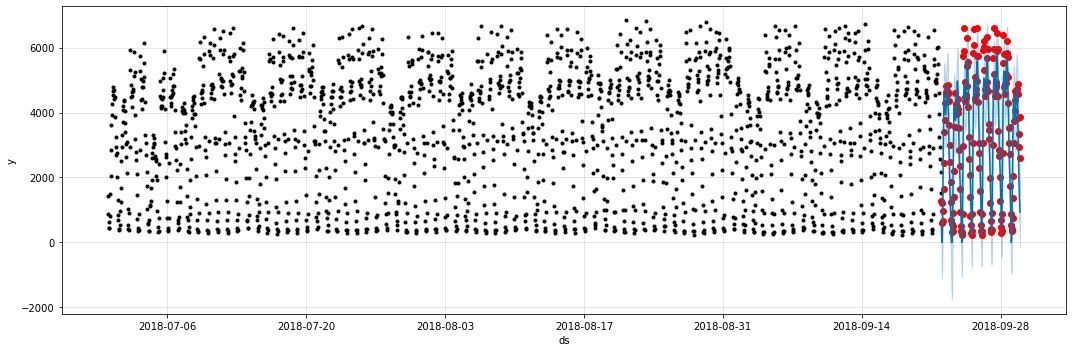

In [29]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.y, color='r')
fig2 = model_with_temp.plot(y_pred_mr, ax=ax)

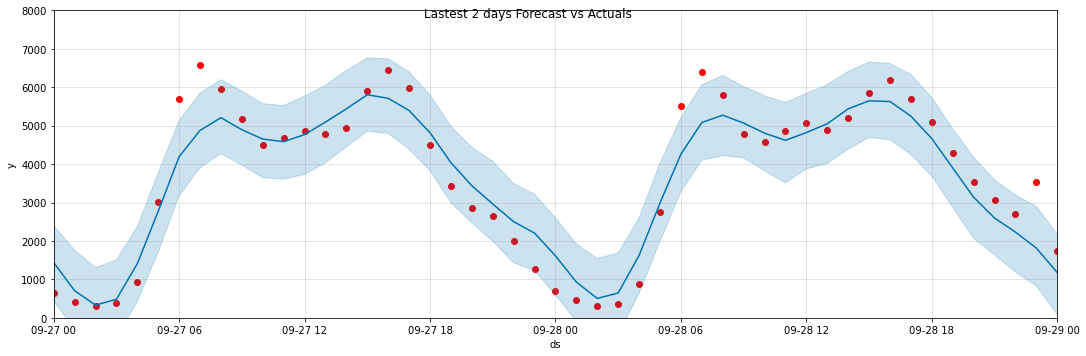

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.y, color='r')
fig = model.plot(y_pred_mr, ax=ax)
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))

ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest 2 days Forecast vs Actuals')

**Error Metrics**

In [31]:
error_metrics(ts_test.y, y_pred_mr['yhat'])

Mean Absolute Error: 626.79
Root Mean Squared Error: 837.53
Mean Absolute percentage Error: 36.02 %


### Optimizing the model
ref : https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [32]:
ts_train['cap'] = 8000
ts_train['floor'] = 0
ts_test['cap'] = 8000
ts_test['floor'] = 0

In [33]:
%%time
# Setup and train model
model = Prophet(growth='linear',
                #holidays=holidays,
                seasonality_mode= 'additive',
                changepoint_prior_scale=10,
                seasonality_prior_scale=0.01,
                #holidays_prior_scale=20,
                daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False
               ).add_seasonality(name = 'monthly', period = 30.5, fourier_order=20
               ).add_seasonality(name= 'daily', period= 1, fourier_order= 12
               ).add_seasonality(name= 'weekly', period= 7, fourier_order= 24)
model.add_regressor('temp')
model.add_regressor('rain_1h')
model.add_regressor('snow_1h')
model.add_regressor('clouds_all')

model.fit(ts_train)

Wall time: 31.4 s


In [34]:
%%time
# Predict on training set with model
y_pred_op = model.predict(df=ts_test)
y_pred_op.yhat[y_pred_op.yhat < 0] = 0

Wall time: 2.57 s


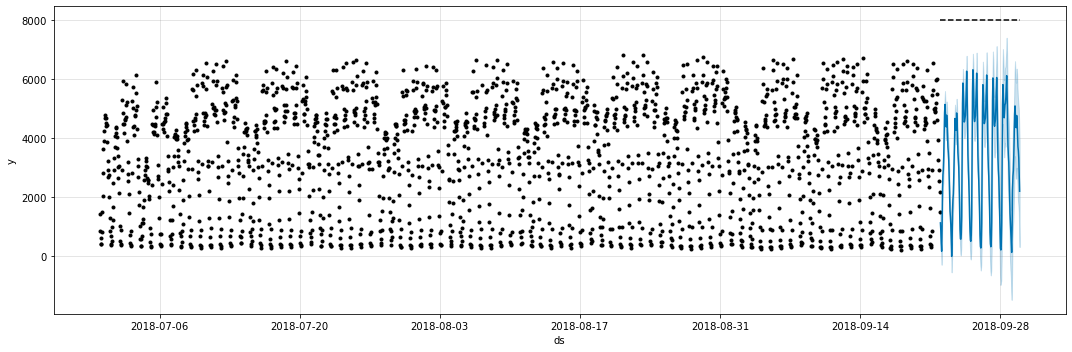

In [35]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(y_pred_op, ax=ax)


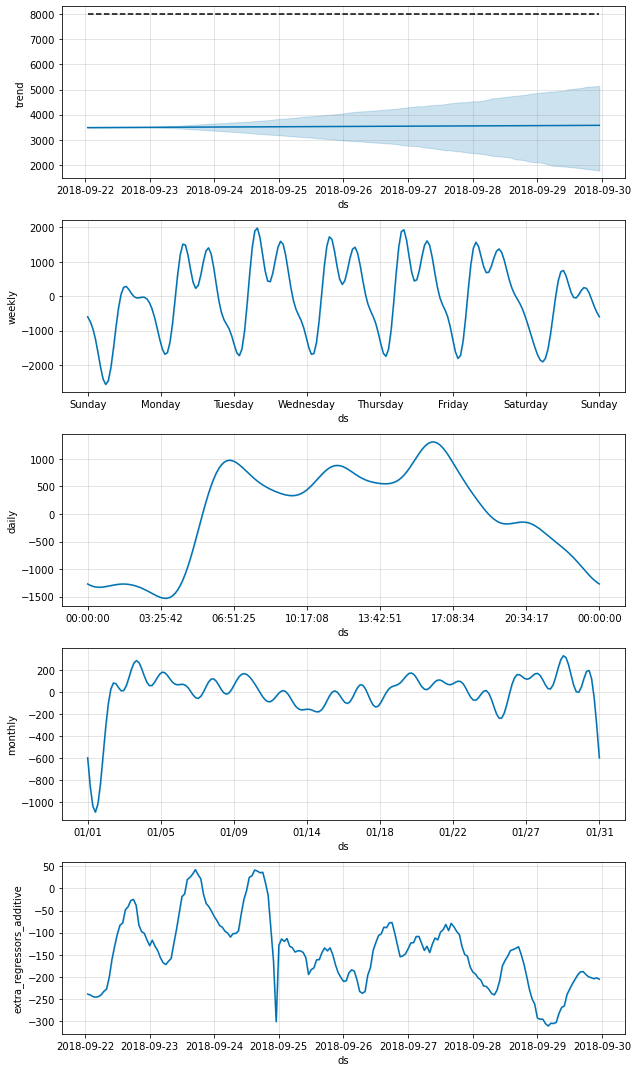

In [36]:
# Plot the components
fig = model.plot_components(y_pred_op)

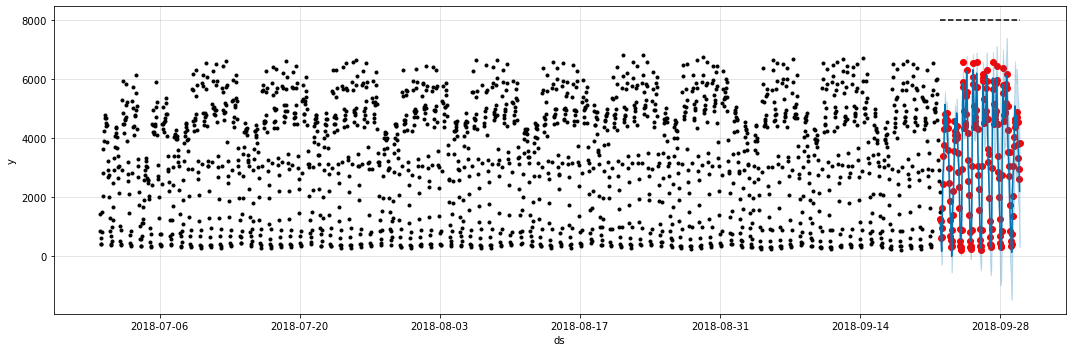

In [37]:
#### Compare Forecast to Actuals

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.y, color='r')
fig = model.plot(y_pred_op, ax=ax)

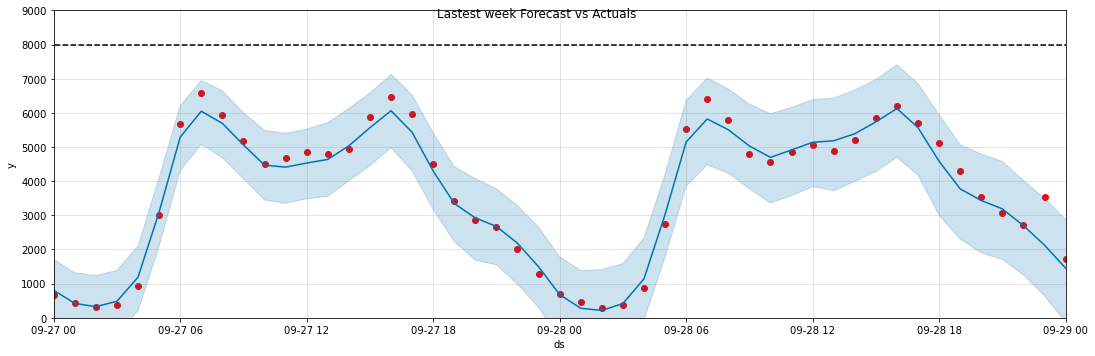

In [38]:
#Lastest week predictions

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.y, color='r')
fig = model.plot(y_pred_op, ax=ax)
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))

ax.set_ylim(0, 9000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')


**Error Metrics**

In [39]:
error_metrics(ts_test.y, y_pred_op['yhat'])

Mean Absolute Error: 293.86
Root Mean Squared Error: 380.87
Mean Absolute percentage Error: 18.40 %
